In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
df_wine = pd.read_csv('datasets/wine.data', header=None)

from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# STANDARDIZE THE DATA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

Mean vectors for Wine dataset

In [24]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' %(label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Constructing the Scatter Matrix

In [25]:
# WITHIN CLASS SCATTER MATRIX

d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' %(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [26]:
# normalized Withhin class Scatter
d = 13
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' %(S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [27]:
# BETWEEN CLASS SCATTER MATRIX

mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in  enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n*(mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' %(S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


The Remaining Steps

In [28]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
for eigen_val in eigen_pairs:
    print(eigen_val[0])

349.617808905994
172.7615221897938
3.939820615533238e-14
2.842170943040401e-14
1.7925907004994513e-14
1.628242860393441e-14
1.628242860393441e-14
1.1916379099674516e-14
1.1916379099674516e-14
8.08514340562765e-15
5.617170912153432e-15
5.617170912153432e-15
4.981875933861479e-15


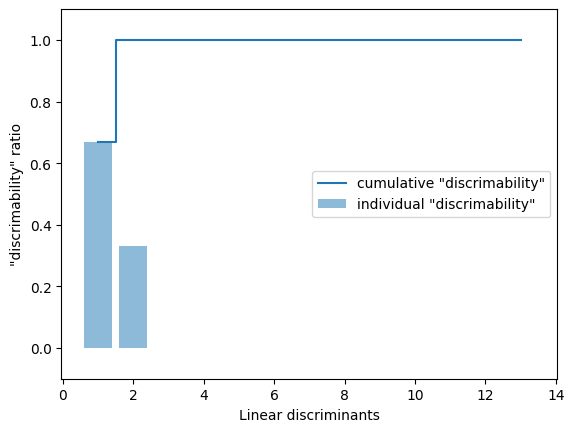

In [29]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discrimability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discrimability"')
plt.ylabel('"discrimability" ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')

In [30]:
# Two most discriminative eigenvectors columns to create the transformation matrix W

W = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print(W)

[[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


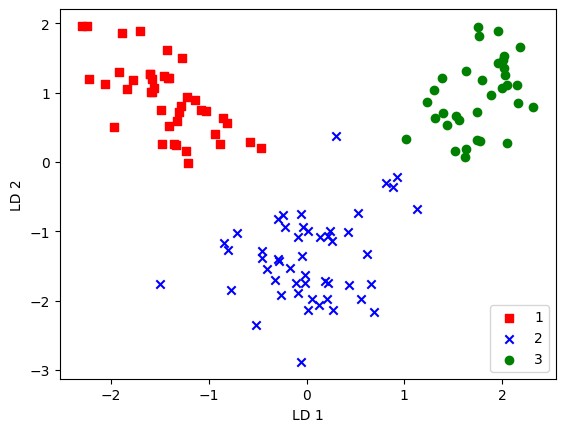

In [31]:
X_train_lda = X_train_std.dot(W)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1]*(-1), c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')